# BBH Postmerger GW Representations

This notebook explores the time-, frequency- and time-frequency representations of BBH merger/post-merger signals


In [675]:
%matplotlib inline
import matplotlib
import sys, os, h5py
import copy
import numpy as np
from matplotlib import pyplot as plt
import cwt
from scipy.interpolate import interp1d

import lal
import pycbc.waveform as wfutils
from pycbc.waveform import get_td_waveform,taper_timeseries
from pycbc.types import FrequencySeries
from pycbc.filter import sigma as optimal_snr

fig_width_pt = 510.
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fontsize = 16
legendfontsize = 14

params={'text.usetex': True,
        'axes.labelsize': fontsize,
        'font.size': fontsize,
        'legend.fontsize': legendfontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.figsize': fig_size,
        'font.weight': 'normal'
       }


import pylab
pylab.rcParams.update(params)
pylab.rcParams['axes.linewidth'] = 1
pylab.rc('axes', linewidth=1)

def touchbox(ax):
    ax.minorticks_on()
    ax.tick_params('both', length=5, width=1, which='major')
    ax.tick_params('both', length=3.5, width=1, which='minor')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    return

# plt.style.use('seaborn-darkgrid')


## Configuration
The following sections define where to save data, the BBH waveform to generate and the resolution of our time-frequency maps, generated via continuous wavelet transforms.

### File Configuration
 * `savepath`: figures will be saved to this directory of the container
 * `numrel_data`: The numerical relativity simulation to use

In [676]:
savepath = "/bbh-tfmaps"
numrel_data = '/waves/GT0577.h5'


### Waveform configuration
 * `mass`: total mass of the system in solar masses
 * `sample_frequency`: frequency with which the digitized time-series is sampled.  Time spacing between samples is `1/sample_frequency`


In [677]:
mass=100
sample_frequency = 4096

### Orientation
 * `phi`: coalescence phase; determined by the azimuthal angle around the system
 * `iota`: inclination of orbital plane with respect to the line-of-sight, *at the start of the simulation*


In [678]:
phi=6.10865238198
iota=np.pi/2

### Time-frequency Decomposition
This section determines the range of frequencies we observe, and the resolution of the time-frequency maps.
 * `mother_freq`: frequency of the mother wavelet
 * `max_scale`: maximum wavelet scale
Note that the frequency space of the spectrogram is given by:
```
fmin=sample_frequency*mother_freq/max_scale
fmax=sample_frequency*mother_freq
```

In [679]:
# Transform parameters
mother_freq=0.5
max_scale=512

## Waveform generation
Read the input numerical relativity data from the HDF5 file and generate the corresponding gravitational wave signal using the parameters in this notebook.


In [680]:
wavelabel=os.path.join(savepath, numrel_data.split('/')[-1].replace(".h5",""))

f = h5py.File(numrel_data, 'r')

hp, hc = get_td_waveform(approximant='NR_hdf5',
                             numrel_data=numrel_data,
                             mass1=f.attrs['mass1']*mass,
                             mass2=f.attrs['mass2']*mass,
                             spin1z=f.attrs['spin1z'],
                             spin2z=f.attrs['spin2z'],
                             delta_t=1.0/sample_frequency,
                             f_lower=30.,
                             inclination=iota,
                             coa_phase=phi,
                             distance=1000)

f.close()

# Taper waveform for smooth FFTs
hp = taper_timeseries(hp, tapermethod="TAPER_START")
hc = taper_timeseries(hc, tapermethod="TAPER_START")

amp = wfutils.amplitude_from_polarizations(hp,hc)
foft = wfutils.frequency_from_polarizations(hp,hc)

# Shift time origin to merger
sample_times = amp.sample_times - amp.sample_times[np.argmax(amp)]

# # Trim the timeseries before the CWT
# hp_red = hp[:int(sample_frequency)]

## Time-Frequency Decomposition
Here, we decompose the time series data into a time frequency representation (i.e., image) for image classification.  In this example, we use a [continuous wavelet transform](https://www.mathworks.com/help/wavelet/continuous-wavelet-analysis.html?requestedDomain=true) ("CWT").

In [681]:
fmin=sample_frequency*mother_freq/max_scale
fmax=sample_frequency*mother_freq

cwt_result = cwt.build_cwt(hp.data, sample_times, 
                           mother_freq=mother_freq, 
                           max_scale=max_scale)

wfreqs = cwt_result['frequencies']
wplane = cwt_result['map']

# Interpolate the spectrogram to a finer frequency grid for smoother plots
# XXX: worth checking that we don't introduce artifacts here
interpolant = interp1d(wfreqs, wplane, axis=0)
wfreqs = np.arange(wfreqs.min(), max_scale)
wplane = interpolant(wfreqs)

# Results

## Physical units
This set of plots are given in the physical units of the waveform, such that time is in seconds, frequency is in Hertz and gravitational wave strain is dimensionless

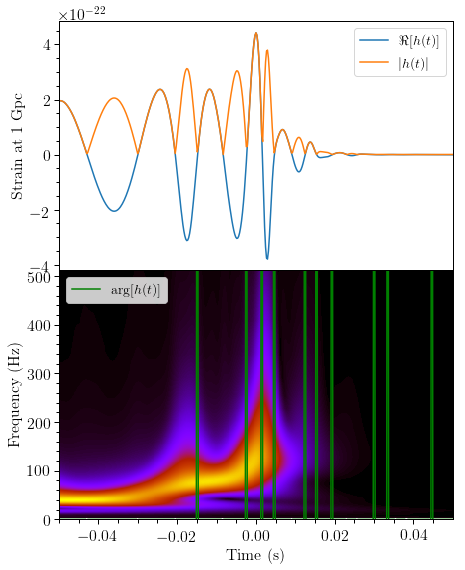

In [682]:
plt.close('all')
fig, ax = plt.subplots(figsize=(fig_width, 2.1*fig_height), 
                       sharex=True, nrows=2)


#
# Time series
#
a = ax[0].plot(sample_times, hp, label=r'$\Re[h(t)]$')
b = ax[0].plot(sample_times, amp, label=r'$|h(t)|$')
ax[0].legend()

#
# Spectrogram
#
p_qstrain = ax[1].pcolormesh(sample_times, wfreqs, (abs(wplane)),
                          rasterized=False,
                         vmin=0,vmax=1,cmap='gnuplot')

#
# Frequency series
#
# FIXME: why is frequency negative??
ax[1].plot(sample_times[:-1], -1*foft, label=r'$\arg[h(t)]$', 
           color='green', linestyle='-')

ax[1].legend(loc='upper left')

# XXX Do not delete this, in case we want a colorbar later
# cbaxes = fig.add_axes([0.1275, 0.9, 0.77, 0.03]) 
# cbar=fig.colorbar(p_qstrain, orientation='horizontal', cax=cbaxes)
# cbar.ax.xaxis.set_ticks_position('top')
# cbar.ax.xaxis.set_label_position('top')
# ax.clabel(c_qstrain, inline=1, fmt="%.1f", fontsize=14)


for i in xrange(len(ax)):
    
    ax[i].set_xlim(-0.05,0.05)
    
    if i==0:
        ax[i].set_ylabel(r'$\textrm{Strain at 1 Gpc}$')
    if i==1:
        ax[i].set_ylim(0,max_scale)
        ax[i].set_xlabel(r'$\textrm{Time (s)}$')
        ax[i].set_ylabel(r'$\textrm{Frequency (Hz)}$')
        
    # Beautify the lines
    touchbox(ax[i])
    
plt.subplots_adjust(hspace=0)

# Determine figure name from numrel file and orientation
figname=os.path.join(savepath, 
                     os.path.basename(numrel_data).replace('.h5','')
                     +'_iota-%f'%(iota*180/np.pi)+'_phi-%f'%(phi*180/np.pi)+'.png')
plt.savefig(figname)
    
plt.show()

## Natural / geometric units
Here we rescale the data such that $$G=c=1$$ and time is in solar masses in seconds, frequency is in units of 1/solar mass and strain amplitude is in solar masses in meters.

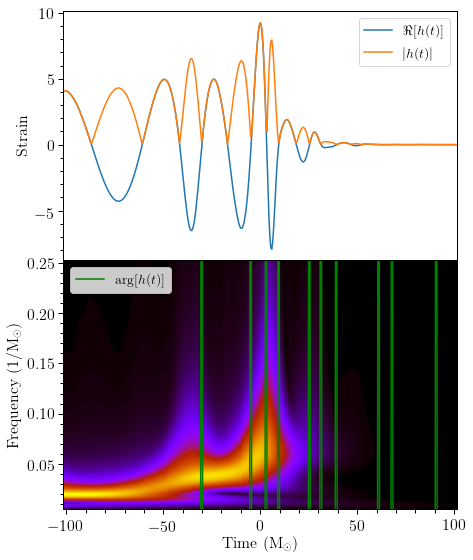

In [683]:

mscale_sec=lal.MTSUN_SI*mass
mscale_mpc=1/ ( lal.MRSUN_SI / ( 1000 * lal.PC_SI * 1.0e6) )

plt.close('all')
fig, ax = plt.subplots(figsize=(fig_width, 2.1*fig_height), 
                       sharex=True, nrows=2)


#
# Time series
#
ax[0].plot(sample_times/mscale_sec, hp*mscale_mpc, label=r'$\Re[h(t)]$')
a = ax[0].plot(sample_times/mscale_sec, amp*mscale_mpc, label=r'$|h(t)|$')
ax[0].legend()

#
# Spectrogram
#
p_qstrain = ax[1].pcolormesh(sample_times/mscale_sec, wfreqs*mscale_sec, 
                             (abs(wplane)), cmap='gnuplot', 
                             rasterized=False, vmin=0,vmax=1)

#
# Frequency series
#
# FIXME: why is frequency negative??
ax[1].plot(sample_times[:-1]/mscale_sec, -1*foft*mscale_sec, 
           label=r'$\arg[h(t)]$', color='g')

ax[1].legend(loc='upper left')


for i in xrange(len(ax)):
    
    ax[i].set_xlim(-0.05/mscale_sec,0.05/mscale_sec)
    
    if i==0:
        ax[i].set_ylabel(r'$\textrm{Strain}$')
    if i==1:
        ax[i].set_ylim(10*mscale_sec,max_scale*mscale_sec)
        ax[i].set_xlabel(r'$\textrm{Time }(\textrm{M}_{\odot})$')
        ax[i].set_ylabel(r'$\textrm{Frequency }(1/\textrm{M}_{\odot})$')

    # Beautify the lines
    touchbox(ax[i])
    
plt.subplots_adjust(hspace=0)
    
plt.savefig(figname.replace('.png', '_GEOM.png'))    

plt.show()